In [1]:
import numpy as np
import os
from tqdm import tqdm

## Loading Descriptions
Image Caption are stored in Flickr8k.token.txt seperated by a new line
eachline consist of name of the image followed by space(tab) and description

In [2]:
# load_description_data function
# Input: description_path (str) - Path to the description file
# Output: mapping (dict) - Mapping of Image and its descriptions (one image can have multiple descriptions)
def load_description_data(description_path: str):
    raw_text = open(description_path, 'r', encoding='utf-8').read()
    
    # Mapping of Image and its descriptions (one image can have multiple descriptions)
    mapping = dict()

    # Iterate through each line of the file
    for line in raw_text.split('\n'):
        token = line.split("\t") # Seperate Image name and Description
        
        # Filter out lines with less than 2 elements (i.e. no image name or description)
        if len(line) < 2:
            continue

        image_id          = token[0].split('.')[0]
        image_description = token[1]

        # If image id is not present in the mapping, add it
        if image_id not in mapping:
            mapping[image_id] = list()
        
        # Add description to the mapping
        mapping[image_id].append(image_description)
    
    return mapping

## Cleaning the text

Remove noise so that our NLP machine can easily detect pattern in the text. In the case of Flicker8K dataset noise will come in numbers and special character which will be quite are for machine to understand (I am not OpenAI lmao)

In [3]:
# clean_descriptions_data function
# Input: description_mapping (dict) - Mapping of Image and its descriptions from load_description_data function
# Output: None - Modifies the description_mapping in place
def clean_descriptions_data(description_mapping: dict):
    # image_id (str) - Image name
    # descriptions (list) - List of descriptions for the image
    for image_id, descriptions in description_mapping.items():
        # Iterate through each description
        for i in range(len(descriptions)):
            description = descriptions[i]                                                          # Query description
            description = description.split()                                                      # Split description into words
            description = [word.lower() for word in description if len(word)>1 and word.isalpha()] # Remove single character words and punctuations (i.e. 'a', '!')
            description = ' '.join(description)                                                    # Join words back into a sentence
            descriptions[i] = description                                                          # Replace description with cleaned description

## Generate Unique Vocabs
Vocabulary is a set of unique word present in the text corpus (all vocab our model will know - Similar to Human you don't understand Chinese Words lmao)

In [4]:
def get_vocabs(description_mapping: dict):
    # Create a set of all unique words
    vocab = set()          

    # Iterate through each image and its descriptions
    for image_id in description_mapping.keys():
        # Iterate through each description
        for description in description_mapping[image_id]:
            # Union all words in the description to the set (Word can be portrayed as vocabulary - I am not a linguist pls don't take my word for it 💀)       
            vocab.update(description.split())
    return vocab

## Load text data

In [5]:
# Load Raw Description Data
descriptions = load_description_data('Flickr_Data/Flickr_TextData/Flickr8k.token.txt')
print("Raw Description Data Demo    :", descriptions['1000268201_693b08cb0e'])

# Clean Description Data
clean_descriptions_data(descriptions)
print("Cleaned Description Data Demo:", descriptions['1000268201_693b08cb0e'])

# Get Vocabularies
vocab = get_vocabs(descriptions)
print("Vocabularies Demo            :", list(vocab)[:10])

Raw Description Data Demo    : ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
Cleaned Description Data Demo: ['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']
Vocabularies Demo            : ['patroling', 'motorbiker', 'backpack', 'lamb', 'desk', 'library', 'african', 'kakhi', 'genetic', 'plains']


## Load Dataset Descriptions
Map images in the training set to their corresponding descriptions
Create a list of training_images file name and then create a empty dictionary and map to their descriptions using image name as key

In [6]:
import glob

# Create a list of all image names
images_dir = 'Flickr_Data/Images'
image_paths = glob.glob(images_dir + '/*.jpg')

# List of all training image names
train_image_texts = 'Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
train_image_names = open(train_image_texts, 'r').read().split('\n')

# List to store paths of training images
train_image_paths = []
for image_path in image_paths:
    # Check if image is in the training set by comparing its name
    if image_path[len(images_dir) + 1:] in train_image_names:
        train_image_paths.append(image_path)

# Function to load descriptions for the training dataset
# Input: description_mapping (dict) - Mapping of image names to descriptions
#        image_paths (list) - List of image paths
# Output: dataset (dict) - Mapping of image names to preprocessed descriptions
def load_description_dataset(description_mapping: dict, image_paths: list):
    dataset = dict()

    for image_id, descs in description_mapping.items():
        
        expected_path = image_id + '.jpg'

        # Check if image in list of image of interest to built dataset
        if expected_path in image_paths:

            # If image id is not present in the dataset, add it
            if image_id not in dataset:
                dataset[image_id] = list()
            
            # Add description to the dataset
            for desc in descs:
                dataset[image_id].append('<start> ' + desc + ' <end>')
            
    return dataset
            
# Load Training Dataset
# Sub Sample of variable descriptions for those who still don't understand 🤣
train_descriptions = load_description_dataset(descriptions, train_image_names)

## Image Features Extraction
For our model to understand the image we have to extract feature from the image in a machine understandable way not human aka computer do not have eyes lmao.
We will use pretrained InceptionV3 to extract these feature by taking output of the model that would be feed to classification model as the features

In [21]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model

# Load InceptionV3 Model pretrained on ImageNet dataset
base_model = InceptionV3(weights='imagenet')

# Remove the last 2 layers of the model (i.e. the classification layers -> softmax and predictions)
model_inception = Model(base_model.input, base_model.layers[-2].output)


# Load Image for InceptionV3
def preprocess_img(img_path: str):
    
    # Inception V3 expects image to be of size (1, 299, 299, 3)
    img = load_img(img_path, target_size=(299, 299))

    x = img_to_array(img)           # Convert image to numpy array    
    x = np.expand_dims(x, axis=0)   # Add one more dimension to the image (i.e. (299, 299, 3) -> (1, 299, 299, 3))

    x = preprocess_input(x)         # Preprocess the image for InceptionV3

    # Image ready for InceptionV3
    return x

# Perform Feature Extraction using InceptionV3 aka encode image with DL model
def encode_image(img_path: str):

    img = preprocess_img(img_path)          # Preprocess image for InceptionV3

    code = model_inception.predict(img, verbose=0)    # Encode image with InceptionV3
    code = np.reshape(code, code.shape[1])  # Reshape from (1, 2048) to (2048, )

    return code


In [8]:
# Encode all training images
train_image_encoded = {}
for img in tqdm(train_image_paths):
    train_image_encoded[img[len(images_dir) + 1:].replace('.jpg', '')] = encode_image(img)


  0%|          | 0/6000 [00:00<?, ?it/s]2023-07-02 13:11:58.100035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-02 13:12:00.516017: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-02 13:12:00.529865: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.2.89, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

100%|██████████| 6000/6000 [08:56<00:00, 11.18it/s]


## Tokenizing the Vocabulary
Tokenized all the vocab presented in our Corpus

In [9]:
# Create a list of all training captions [caption, caption, caption, ...]
all_train_captions = [caption for captions in train_descriptions.values() for caption in captions]

# Filter out words that occur less than 10 times to reduce vocabulary size
threshold = 10

# Create a dictionary of word and its count
word_counts = {}
for caption in all_train_captions:
    for word in caption.split():
        word_counts[word] = word_counts.get(word, 0) + 1

# Filtering
vocab = [word for word in word_counts if word_counts[word] >= threshold]

word2int = {word: index for index, word in enumerate(vocab, 1)}
int2word = {index: word for index, word in enumerate(vocab, 1)}

# Find max length of a caption in the training set
max_length = max(len(caption.split()) for captions in train_descriptions.values() for caption in captions)

## X-Y Extraction

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Prepare dataset for training
# X1 - Image Features
# X2 - Input Sequence
# y  - Output Word
X1, X2, y = [], [], []

# Iterates over each train_descriptions retrieves the corresponding iamge feature from train_image_encoded dictionary
for key, captions in train_descriptions.items():
    # Extract image features vector
    img = train_image_encoded[key]

    # Iterate through each description for the image
    for caption in captions:
        seq = [word2int[word] for word in caption.split() if word in word2int]  # Convert caption to sequence of integers
        
        # Iterate through each word in the sequence to generate what come next for each words
        for i in range(1, len(seq)):

            in_seq, out_seq = seq[:i], seq[i]  # Split sequence into input and output pair

            # FAQ: Why one-hot encode the output sequence?
            # Ans: LSTM need one hot output while embedding layer need integer input hence we need to one-hot encode the output sequence but not the input sequence
            # Pad input sequence to make it the same length as max_length
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # One-hot encode output sequence
            out_seq = to_categorical([out_seq], num_classes=len(vocab) + 1)[0]

            # Append to dataset
            X1.append(img)
            X2.append(in_seq)
            y.append(out_seq)


# Convert to numpy array
X1, X2, y = np.array(X1), np.array(X2), np.array(y)


## GloVe Vector Embeddings

GloVe stands for global vectors for word representation helps computers understand the meaning of words by representing them as numbers.
Vector representation of Corgi and Husky will be quite similar


In [11]:
glove_path = 'glove.6B.200d.txt'
glove = open(glove_path, 'r').read().split('\n')

# Create a dictionary of word and its embedding
embeeding_index = {}

# Doing something similar to opening a dictionary for word meaning - {word} {vector}
for line in tqdm(glove):
    try:
        values = line.split()
        # Get both the word and the vector
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')

        # Add to dictionary
        embeeding_index[word] = vector
    except IndexError:
        pass
# Generate embedding matrix
embedding_dim = 200
embedding_matrix = np.zeros((len(vocab) + 1, embedding_dim))
for word, index in word2int.items():
    embedding_vector = embeeding_index.get(word)

    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

100%|██████████| 400001/400001 [00:16<00:00, 23915.63it/s]


## DEEP DARK LEARNING MODEL
Our model will have 3 major steps
1. Processing Sequence of text
2. Extracting the feature vector from the image
3. Decoding the output by concatenating 1. and 2.

Model reference from article by dark_coder88

In [12]:
# Print Dataset Dimension
print('X1.shape:', X1.shape)    # Image Features
print('X2.shape:', X2.shape)    # Input Sequence
print('y.shape:', y.shape)      # Output Word

X1.shape: (292045, 2048)
X2.shape: (292045, 33)
y.shape: (292045, 1644)


In [13]:
from tensorflow.keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation, concatenate, BatchNormalization, Input, Concatenate


# Why len(vocab) + 1?
# Ans: Because we need to add a padding token to the vocabulary

# 1. Process Image
input_1     = Input(shape=(2048,))  # Image Features
dropout_1   = Dropout(0.2)(input_1) # Dropout Layer
dense_1     = Dense(256, activation='relu')(dropout_1) # Fully Connected Layer

# 2. Process Text 
input_2     = Input(shape=(max_length,)) # Input Sequence
embedding_2 = Embedding(len(vocab)+1, embedding_dim, mask_zero=True)(input_2) # Embedding Layer
dropout_2   = Dropout(0.2)(embedding_2) # Dropout Layer
lstm_2      = LSTM(256)(dropout_2) # LSTM Layer

# 3. Merge Image and Text 
merge_3       = Concatenate()([dense_1, lstm_2]) # Concatenate Layer
dense_3       = Dense(256, activation='relu')(merge_3) # Fully Connected Layer
outputs       = Dense(len(vocab)+1, activation='softmax')(dense_3) # Output Layer

# Model
model = Model(inputs=[input_1, input_2], outputs=outputs)

# Set embedding layer weights
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')


In [66]:
import json

def save_dictionary_as_json(dictionary, file_path):
    try:
        with open(file_path, 'w') as file:
            json.dump(dictionary, file)
        print("Dictionary saved as JSON successfully.")
    except Exception as e:
        print(f"Error saving the dictionary as JSON: {str(e)}")

# Example usage
save_dictionary_as_json(word2int, 'word2int.json')
save_dictionary_as_json(int2word, 'int2word.json')


Dictionary saved as JSON successfully.
Dictionary saved as JSON successfully.


### Train Model

In [14]:
from tensorflow.keras.callbacks import TensorBoard

log_dir = "./logs"  # Directory where the log files will be saved
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, update_freq='epoch')

# Start training the model with the TensorBoard callback
model.fit([X1, X2], y, epochs=50, batch_size=256, verbose=2, callbacks=[tensorboard_callback])

2023-07-02 13:21:26.334567: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2392432640 exceeds 10% of free system memory.
2023-07-02 13:21:32.339231: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1920487920 exceeds 10% of free system memory.
2023-07-02 13:21:34.756090: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2392432640 exceeds 10% of free system memory.
2023-07-02 13:21:35.642768: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1920487920 exceeds 10% of free system memory.


Epoch 1/50


2023-07-02 13:21:43.977019: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_23'
2023-07-02 13:21:44.555447: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fd4508f5ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-02 13:21:44.555563: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 with Max-Q Design, Compute Capability

1141/1141 - 253s - loss: 3.9031 - 253s/epoch - 221ms/step
Epoch 2/50
1141/1141 - 210s - loss: 3.1635 - 210s/epoch - 184ms/step
Epoch 3/50
1141/1141 - 220s - loss: 2.9219 - 220s/epoch - 193ms/step
Epoch 4/50
1141/1141 - 212s - loss: 2.7636 - 212s/epoch - 186ms/step
Epoch 5/50
1141/1141 - 224s - loss: 2.6461 - 224s/epoch - 197ms/step
Epoch 6/50
1141/1141 - 234s - loss: 2.5475 - 234s/epoch - 205ms/step
Epoch 7/50
1141/1141 - 220s - loss: 2.4659 - 220s/epoch - 193ms/step
Epoch 8/50
1141/1141 - 222s - loss: 2.3948 - 222s/epoch - 195ms/step
Epoch 9/50
1141/1141 - 210s - loss: 2.3319 - 210s/epoch - 184ms/step
Epoch 10/50
1141/1141 - 207s - loss: 2.2793 - 207s/epoch - 181ms/step
Epoch 11/50
1141/1141 - 204s - loss: 2.2287 - 204s/epoch - 179ms/step
Epoch 12/50
1141/1141 - 204s - loss: 2.1861 - 204s/epoch - 179ms/step
Epoch 13/50
1141/1141 - 204s - loss: 2.1443 - 204s/epoch - 178ms/step
Epoch 14/50
1141/1141 - 202s - loss: 2.1084 - 202s/epoch - 177ms/step
Epoch 15/50
1141/1141 - 205s - loss: 2.0

In [15]:
model.save('models')

2023-07-02 16:16:34.069234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-02 16:16:34.071780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-02 16:16:34.073574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


## Predicting

In [69]:
model.load_weights('saved')

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for saved

In [70]:
def predict(img_file):

    # Load and resize image
    img = encode_image(img_file).reshape((1, 2048))

    start = '<start>'

    for i in range(max_length):
        
        # Convert caption to sequence of integers
        seq = [word2int[word] for word in start.split() if word in word2int]
        
        # Pad sequence to make it the same length as max_length to feed into the model
        seq = pad_sequences([seq], maxlen=max_length)

        predict_word = model.predict([img, seq], verbose=0)
        predict_word = np.argmax(predict_word)
        word = int2word[predict_word]

        start += ' ' + word

        # Model predicts the word <end> we break the loop
        if word == '<end>':
            break
    
    final = start.split()
    
    # Remove <start> and <end> from the final caption
    final = final[1:-1]

    return ' '.join(final)


Caption: the dog is jumping into the water


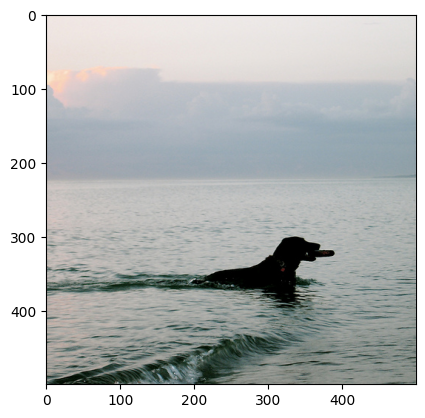

In [74]:
# Test Image from the test set

# Randomly select an image from the test set
images_dir = 'Flickr_Data/Images'
image_paths = glob.glob(images_dir + '/*.jpg')

# Randomly select an image that is not in the training set
test_paths = list(set(image_paths) - set(train_image_paths))

# Randomly select an image
img_path = test_paths[np.random.randint(0, len(test_paths))]

# Display the image
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(img_path)

# Print the image caption
print('Caption:', predict(img_path))

plt.imshow(img)


In [75]:
predict('g.jpg')

'brown and white dog is trotting through the water'